##**5. Seq2seq**
1. Encoder를 구현합니다.
2. Decoder를 구현합니다.
3. Seq2seq 모델을 구축하고 사용합니다.

### **필요 패키지 import**

In [3]:
from tqdm.auto import tqdm
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import torch

import random

### **데이터 전처리**

`src_data`를 `trg_data`로 바꾸는 task를 수행하기 위한 sample data입니다.  
전체 단어 수는 $100$개이고 다음과 같이 pad token, start token, end token의 id도 정의합니다.

In [2]:
vocab_size = 100
pad_id = 0
sos_id = 1
eos_id = 2

src_data = [
  [3, 77, 56, 26, 3, 55, 12, 36, 31],
  [58, 20, 65, 46, 26, 10, 76, 44],
  [58, 17, 8],
  [59],
  [29, 3, 52, 74, 73, 51, 39, 75, 19],
  [41, 55, 77, 21, 52, 92, 97, 69, 54, 14, 93],
  [39, 47, 96, 68, 55, 16, 90, 45, 89, 84, 19, 22, 32, 99, 5],
  [75, 34, 17, 3, 86, 88],
  [63, 39, 5, 35, 67, 56, 68, 89, 55, 66],
  [12, 40, 69, 39, 49]
]

trg_data = [
  [75, 13, 22, 77, 89, 21, 13, 86, 95],
  [79, 14, 91, 41, 32, 79, 88, 34, 8, 68, 32, 77, 58, 7, 9, 87],
  [85, 8, 50, 30],
  [47, 30],
  [8, 85, 87, 77, 47, 21, 23, 98, 83, 4, 47, 97, 40, 43, 70, 8, 65, 71, 69, 88],
  [32, 37, 31, 77, 38, 93, 45, 74, 47, 54, 31, 18],
  [37, 14, 49, 24, 93, 37, 54, 51, 39, 84],
  [16, 98, 68, 57, 55, 46, 66, 85, 18],
  [20, 70, 14, 6, 58, 90, 30, 17, 91, 18, 90],
  [37, 93, 98, 13, 45, 28, 89, 72, 70]
]

각각의 데이터를 전처리합니다.

In [4]:
trg_data = [[sos_id] + seq + [eos_id] for seq in tqdm(trg_data)] #시작 토큰 + 문장 + 끝 토큰

  0%|          | 0/10 [00:00<?, ?it/s]

In [5]:
def padding(data, is_src = True):

    max_len = len(max(data, key = len))
    print(f"Maximum sequence length: {max_len}")

    valid_lens = []

    for i,seq in enumerate(tqdm(data)):

        valid_lens.append(len(seq))

        if len(seq) < max_len:

            data[i] = seq + [pad_id] * (max_len - len(seq))

    return data, valid_lens, max_len

In [6]:
src_data, src_lens, src_max_len = padding(src_data)
trg_data, trg_lens, trg_max_len = padding(trg_data)

Maximum sequence length: 15


  0%|          | 0/10 [00:00<?, ?it/s]

Maximum sequence length: 22


  0%|          | 0/10 [00:00<?, ?it/s]

In [7]:
# B: batch size, S_L: source maximum sequence length, T_L: target_maximum sequence length

src_batch = torch.LongTensor(src_data) #(B, S_L)
src_batch_lens = torch.LongTensor(src_lens) #(B)
trg_batch = torch.LongTensor(trg_data) #(B, T_L)
trg_batch_lens = torch.LongTensor(trg_lens) #(B)

print(src_batch.shape)
print(src_batch_lens.shape)
print(trg_batch.shape)
print(trg_batch_lens.shape)

torch.Size([10, 15])
torch.Size([10])
torch.Size([10, 22])
torch.Size([10])


PackedSequence를 사용을 위해 source data를 기준으로 정렬합니다.

In [9]:
src_batch_lens, sorted_idx = src_batch_lens.sort(descending=True)

src_batch = src_batch[sorted_idx]
trg_batch = trg_batch[sorted_idx]

trg_batch_lens = trg_batch_lens[sorted_idx]

print(src_batch)
print(src_batch_lens)
print(trg_batch)
print(trg_batch_lens)

tensor([[39, 47, 96, 68, 55, 16, 90, 45, 89, 84, 19, 22, 32, 99,  5],
        [41, 55, 77, 21, 52, 92, 97, 69, 54, 14, 93,  0,  0,  0,  0],
        [63, 39,  5, 35, 67, 56, 68, 89, 55, 66,  0,  0,  0,  0,  0],
        [ 3, 77, 56, 26,  3, 55, 12, 36, 31,  0,  0,  0,  0,  0,  0],
        [29,  3, 52, 74, 73, 51, 39, 75, 19,  0,  0,  0,  0,  0,  0],
        [58, 20, 65, 46, 26, 10, 76, 44,  0,  0,  0,  0,  0,  0,  0],
        [75, 34, 17,  3, 86, 88,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [12, 40, 69, 39, 49,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [58, 17,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [59,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])
tensor([15, 11, 10,  9,  9,  8,  6,  5,  3,  1])
tensor([[ 1, 37, 14, 49, 24, 93, 37, 54, 51, 39, 84,  2,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0],
        [ 1, 32, 37, 31, 77, 38, 93, 45, 74, 47, 54, 31, 18,  2,  0,  0,  0,  0,
          0,  0,  0,  0],
        [ 1, 20, 70, 14,  6, 58, 90,

### **Encoder 구현**

In [10]:
embedding_size = 256
hidden_size = 512
num_layers = 2
num_dirs = 2
dropout = 0.1

Bidirectional GRU를 이용한 Encoder입니다.


*   `self.embedding`: word embedding layer.
*   `self.gru`: encoder 역할을 하는 Bi-GRU.
*   `self.linear`: 양/단방향 concat된 hidden state를 decoder의 hidden size에 맞게 linear transformation.

In [11]:
class Encoder(nn.Module):

    def __init__(self):

        super(Encoder, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.gru = nn.GRU(
            input_size = embedding_size,
            hidden_size = hidden_size,
            num_layers = num_layers,
            bidirectional = True if num_dirs > 1 else False,
            dropout = dropout
        )
        self.linear = nn.Linear(num_dirs * hidden_size, hidden_size)

    def forward(self, batch, batch_lens):

        #batch (B,S_L), batch_lens (B) d_w: word embedding size

        batch_emb = self.embedding(batch) #(B, S_L, d_w)
        batch_emb = batch_emb.transpose(0,1) #(S_L, B, d_w)

        packed_input = pack_padded_sequence(batch_emb, batch_lens)

        h_0 = torch.zeros((num_layers * num_dirs, batch.shape[0], hidden_size)) #(num_layers * num_dirs, B,d_h) = (4,B,d_h)

        packed_outputs, h_n = self.gru(packed_input, h_0) #h_n: (4,B,d_h)
        outputs = pad_packed_sequence(packed_outputs)[0] #outputs: (S_L, B, 2d_h)

        #split & concat bidirectional hidden states

        forward_hidden = h_n[-2, :, :]
        backward_hidden = h_n[-1, :, :]

        hidden = self.linear(torch.cat((forward_hidden, backward_hidden), dim = -1)).unsqueeze(0) #(1,B,d_h)

        return outputs, hidden

In [12]:
encoder = Encoder()

### **Decoder 구현**

동일한 설정의 Bi-GRU로 만든 Decoder입니다.

*   `self.embedding`: word embedding layer.
*   `self.gru`: decoder 역할을 하는 Bi-GRU.
*   `self.output_layer`: decoder에서 나온 hidden state를 `vocab_size`로 linear transformation하는 layer.

In [13]:
class Decoder(nn.Module):

    def __init__(self):

        super(Decoder, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.gru = nn.GRU(
            input_size = embedding_size,
            hidden_size = hidden_size
        )

        self.output_layer = nn.Linear(hidden_size, vocab_size)

    def forward(self, batch, hidden): #batch: (B), hidden: (1,B,d_h)

        batch_emb = self.embedding(batch) #(B,d_w)
        batch_emb = batch_emb.unsqueeze(0) #(1,B,d_w)

        outputs, hidden = self.gru(batch_emb, hidden) #outputs: (1,B,d_h), hidden:(1,B,d_h)

        #V: vocab size
        outputs = self.output_layer(outputs) #(1,B,V)

        return outputs.squeeze(0), hidden

In [14]:
decoder = Decoder()

### **Seq2seq 모델 구축**

생성한 encoder와 decoder를 합쳐 Seq2seq 모델을 구축합니다.


*   `self.encoder`: encoder.
*   `self.decoder`: decoder.

In [15]:
class Seq2Seq(nn.Module):

    def __init__(self, encoder, decoder):

        super(Seq2Seq, self).__init__()

        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src_batch, src_batch_lens, trg_batch, teacher_forcing_prob = 0.5):

        #src_batch: (B,S_L), src_batch_lens: (B), trg_batch:(B,T_L)

        _, hidden = self.encoder(src_batch, src_batch_lens) #hidden:(1,B,d_h)

        input_ids = trg_batch[:,0] #(B)
        batch_size = src_batch.shape[0]
        outputs = torch.zeros(trg_max_len, batch_size, vocab_size) #(T_L, B, V)

        for t in range(1,trg_max_len):

            decoder_outputs, hidden = self.decoder(input_ids, hidden) #decoder_outputs: (B, V), hidden:(1,B,d_h)

            outputs[t] = decoder_outputs
            _,top_ids = torch.max(decoder_outputs, dim = -1)

            #teacher forcing
            #일정 확률로, 예측한 토큰이 아니라, 다음 정답 토큰을 다음 input으로 가져온다
            input_ids = trg_batch[:,t] if random.random() > teacher_forcing_prob else top_ids

        return outputs

In [16]:
seq2seq = Seq2Seq(encoder, decoder)

### **모델 사용해보기**

학습 과정이라고 가정하고 모델에 input을 넣어봅니다.

In [17]:
outputs = seq2seq(src_batch, src_batch_lens, trg_batch)

print(outputs)
print(outputs.shape)

tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        [[ 3.2548e-02,  7.4958e-02, -1.5765e-02,  ...,  8.8005e-02,
           1.4249e-02,  4.5606e-02],
         [ 7.7082e-02,  4.6238e-02, -4.1103e-02,  ...,  7.8608e-02,
          -4.2104e-02,  5.0591e-02],
         [ 3.1556e-02,  6.2551e-02, -2.0081e-02,  ...,  1.1237e-01,
          -4.5791e-02,  5.7145e-02],
         ...,
         [ 4.2912e-02,  5

Language Modeling에 대한 loss 계산을 위해 shift한 target과 비교합니다.

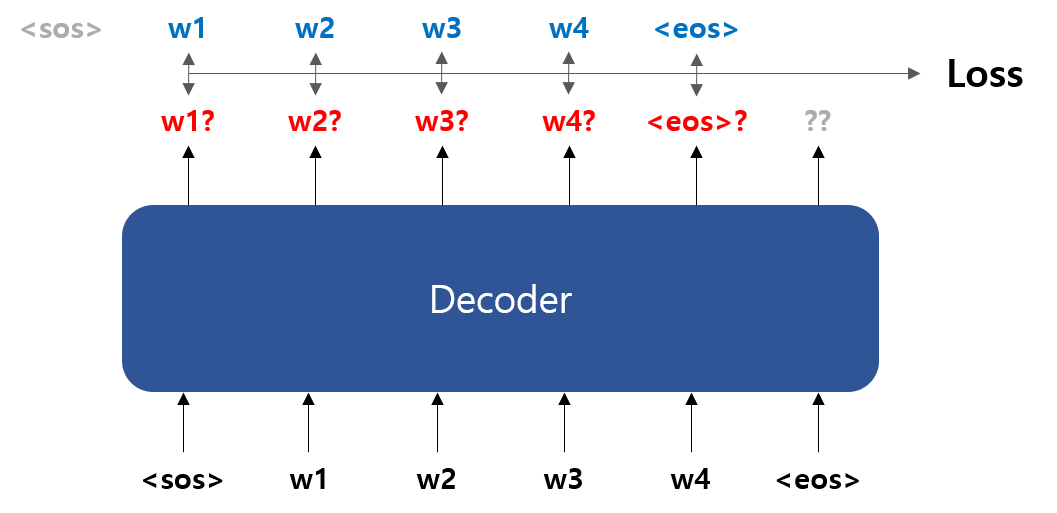

In [18]:
loss_function = nn.CrossEntropyLoss()

preds = outputs[1:,:,:].transpose(0,1) #(B,T_L-1,V)

loss = loss_function(preds.contiguous().view(-1,vocab_size), trg_batch[:,1:].contiguous().view(-1,1).squeeze(1))

print(loss)

tensor(4.5706, grad_fn=<NllLossBackward0>)


실제 inference에선 teacher forcing 없이 이전 결과만을 가지고 생성합니다.

In [20]:
src_batch.shape

torch.Size([1, 8])

In [36]:
src_batch_lens

tensor([ 9,  8,  3,  1,  9, 11, 15,  6, 10,  5])

In [37]:
src_sent = [4,10,88,46,72,34,14,51]

src_len = len(src_sent)

src_batch = torch.LongTensor(src_sent).unsqueeze(0) #(1,L)
src_batch_lens = torch.LongTensor([src_len]) #(1)

_, hidden = seq2seq.encoder(src_batch, src_batch_lens) #hidden: (1,1,d_h)

In [38]:
input_id = torch.LongTensor([sos_id]) #(1)
output = []

for t in range(1,trg_max_len):

    decoder_output, hidden = seq2seq.decoder(input_id, hidden) #decoder_output: (1,V), hidden:(1,1,d_h)

    _,top_id = torch.max(decoder_output,dim = -1) #top_ids:(1)

    if top_id == eos_id:

        break

    else:

        output += top_id.tolist()
        input_id = top_id

print(output)

[59, 97, 97, 84, 81, 20, 58, 67, 20, 58, 68, 24, 46, 13, 78, 29, 33, 48, 48, 8, 23]
